## Домашнее задание №2
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [7]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample
import random
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# %matplotlib inline
# __________end of block__________

In [8]:
# do not change the code in the block below
# __________start of block__________
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("{} device is available".format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [9]:
# do not change the code in the block below
# __________start of block__________
# !wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [10]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ["<sos>"]
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [12]:
# Вспомогательная функция превращающая строку в числа
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = tokens.index(string[c])
    return tensor

print(char_tensor('гусь'))

tensor([48, 64, 62, 73])


Далее вам предстоит написать код для обучения модели и генерации текста.

In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size) # входное кодирование слов
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers) # собственно рекуррентный слой
        self.decoder = nn.Linear(hidden_size, output_size) # линейный выход
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1)) # закодировали вход
        output, hidden = self.gru(input.view(1, 1, -1), hidden) # работа рекуррнтеого слоя
        output = self.decoder(output.view(1, -1)) # выход
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [14]:
chunk_len = 100
text_len = len(text)


def random_chunk():
    start_index = random.randint(0, text_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]


print(random_chunk())

 признаться не хотим.
уж небо осенью дышало,
уж реже солнышко блистало,
короче становился день,
лесов


In [15]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [16]:
def evaluate(prime_str='а', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden() # decoder - наша модель, ее переменная будет позже
    prime_input = char_tensor(prime_str) # кодируем входную строку
    predicted = prime_str # начало выходной строки
    predict_len -= len(prime_str)
    # Используем входную строку для задания hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = tokens[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

In [17]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Основная функция обучения

In [18]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        # print(output, target)
        loss += criterion(output.squeeze(0), target[c]) # в исходной статье ошибочка, тут надо вытянуть в строку

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

In [19]:
a, b = random_training_set()

In [20]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
n_characters = len(tokens)
all_losses = []
decoder = RNN(n_characters, hidden_size, n_characters, n_layers) # собственно наша модель
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr) # оптимищатор
criterion = nn.CrossEntropyLoss()

In [22]:
start = time.time()
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set()) # обучаем модель на сгенерированном батче       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(' мой дядя самых честных правил', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 3s (100 5%) 2.1667]
 мой дядя самых честных правился
же сербений,
серязнит. сердцях вам бедворилу»
ез не все их их посня 

 7s (200 10%) 1.9126]
 мой дядя самых честных правилений,
в веретоский сердце зерод;
в дево нежно всё тотонейся седца,
дох 

 11s (300 15%) 2.0646]
 мой дядя самых честных правил прогдуши,
но в драсталов, первы;
здрастках вдевалы в нежный разомное  

 15s (400 20%) 2.1633]
 мой дядя самых честных правила.
пристой зиги дитенья
слегу передом увела,
про вет шев перси счадом
 

 19s (500 25%) 2.1153]
 мой дядя самых честных правил:
оти в то жела внив,
и праведям от этом,
за бедно с уж он вретел.
уро 

 23s (600 30%) 2.0594]
 мой дядя самых честных правилет.


vii

за забыт. не листаю,
тружу жени данье,
коло нах бездоком ми 

 27s (700 35%) 2.3058]
 мой дядя самых честных правильного робокровой
чугокали люблю в не давили
быть чели мучно моленьем и 

 31s (800 40%) 2.2948]
 мой дядя самых честных правилинык я восекориле;
черное старенье
мложет отворить
осне по мутной в 

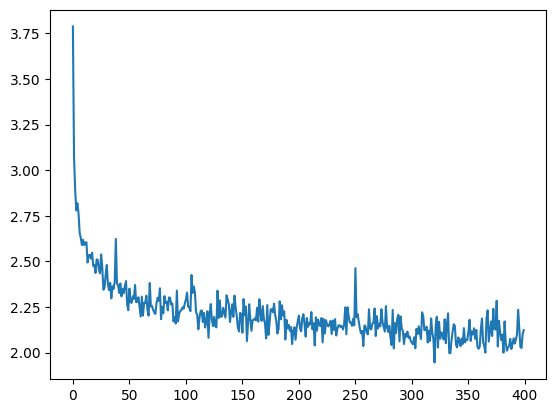

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# %matplotlib inline

plt.figure()
plt.plot(all_losses)

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [129]:
print(evaluate(' мой дядя самых честных правил', 500), '\n')

 мой дядя самых честных правил привым
глоходит немоею чури,
и давичтом, не блежался, что напожет,
соною с мальмы привы проров,
он взданным ногла вы поборы,
возила ты что он онегин,
сметрев и что я ни дус
ей столес, ничевы жежной,
и нежен для ее ты любви;
постать нас но госто не даснно.
и надое, радосятся, голновые,
уж коту спетратные и,
мой, что двна след,
в замоль не старины заред
разумиться, ни ей?
и слуша было виду вдохной.



xvii

ему славым тремяться страснноменный родов
мадет е медлись по 



Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(
    generate_sample(
        model, " мой дядя самых честных правил", max_length=500, temperature=0.8
    )
)

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [24]:
seed_phrase = " мой дядя самых честных правил"

In [25]:
generated_phrases = [evaluate(seed_phrase, 500) for _ in range(10)]

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [30]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'
    

submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!